In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!eotdl version

EOTDL Version: 2025.05.26-4


In [2]:
from glob import glob
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
from rasterio.plot import show
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import os

# Dataset

We label 100 random images from the Satellogic dataset using SCANEO.

In [9]:
path = '/fastdata/Satellogic/data/tifs/satellogic'

images = sorted(glob(os.path.join(path, '*_TOA.tif')))

len(images), images[:3]

(298377,
 ['/fastdata/Satellogic/data/tifs/satellogic/20220701_134034_SN13_21S_663375_6965910_TOA.tif',
  '/fastdata/Satellogic/data/tifs/satellogic/20220701_134034_SN13_21S_664911_6967446_TOA.tif',
  '/fastdata/Satellogic/data/tifs/satellogic/20220701_134034_SN13_21S_665295_6965142_TOA.tif'])

In [10]:
num_images = 100

samples = random.sample(images, num_images)

len(samples), samples[:3]

(100,
 ['/fastdata/Satellogic/data/tifs/satellogic/20220811_191729_SN27_11N_388341_3729255_TOA.tif',
  '/fastdata/Satellogic/data/tifs/satellogic/20221003_183156_SN29_17S_484958_9423756_TOA.tif',
  '/fastdata/Satellogic/data/tifs/satellogic/20220722_195752_SN30_14N_689562_4941198_TOA.tif'])

In [ ]:
dst_path = 'data'
os.makedirs(dst_path, exist_ok=True)

for img in tqdm(samples):
    dst = os.path.join(dst_path, os.path.basename(img))
    if not os.path.exists(dst):
        os.system(f'cp {img} {dst}')

At this point, open SCANEO and label the images.

In [15]:
labels = sorted(glob('data/*.geojson'))

len(labels), labels[:3]

(95,
 ['data/20220709_173334_SN16_14N_425740_5033509_TOA.geojson',
  'data/20220722_195752_SN30_14N_689562_4941198_TOA.geojson',
  'data/20220729_153022_SN27_18S_800063_8428114_TOA.geojson'])

In [16]:
images = [i.replace('geojson', 'tif') for i in labels]

len(images), labels[:3]

(95,
 ['data/20220709_173334_SN16_14N_425740_5033509_TOA.geojson',
  'data/20220722_195752_SN30_14N_689562_4941198_TOA.geojson',
  'data/20220729_153022_SN27_18S_800063_8428114_TOA.geojson'])

Labels coming from SCANEO are in GeoJSON format, and contain labels for the 3 tasks that we want to tackle in the use case: classification, semantic segmentation and object detection.

In [17]:
label = gpd.read_file(labels[1])

label

,label,task,geometry
0,vegetation,segmentation,"MULTIPOLYGON (((-96.61242 44.59585, -96.61242 ..."
1,vegetation,classification,POLYGON EMPTY


The full list of labels with associated colors can be found in the `spai.json` file

In [18]:
import json

with open('data/spai.json', 'r') as f:
    spai_labels = json.load(f)

spai_labels

{'labels': [{'name': 'bare soil', 'color': '#ffea00'},
  {'name': 'urban', 'color': '#ff0000'},
  {'name': 'vegetation', 'color': '#44ff00'},
  {'name': 'water', 'color': '#0033ff'}]}

In [19]:
colors = {label['name']: label['color'] for label in spai_labels['labels']}
colors

{'bare soil': '#ffea00',
 'urban': '#ff0000',
 'vegetation': '#44ff00',
 'water': '#0033ff'}

Let's visualize some samples

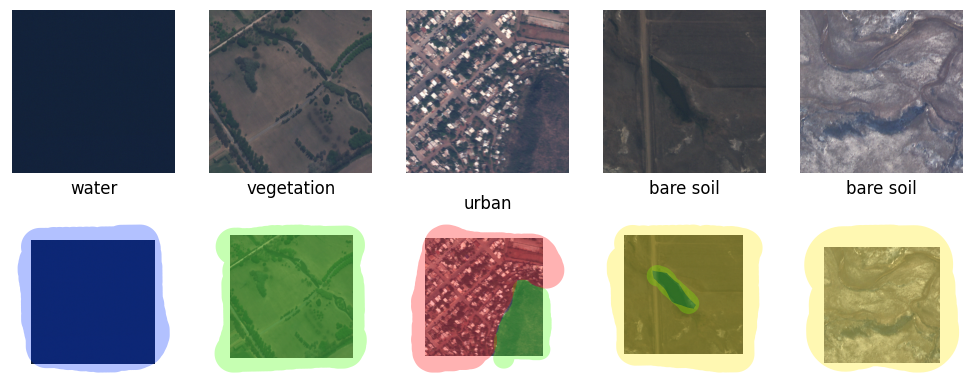

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for col in range(5):
    image = random.choice(images)
    ds = rio.open(image)
    img = np.clip(ds.read([1,2,3]) / 4000, 0, 1)
    axes[0, col].imshow(img.transpose(1,2,0))
    axes[0, col].axis('off')
    label = gpd.read_file(image.replace('tif', 'geojson')).to_crs(ds.crs)
    label['color'] = [colors[l] for l in label['label']]
    classification = label[label['task'] == 'classification']
    # axes[1, col].imshow(np.clip(img / 4000, 0, 1))
    show(img, transform=ds.transform, ax=axes[1, col])
    axes[1, col].axis('off')
    if len(classification) > 0:
        axes[1, col].set_title(', '.join(classification['label'].values))
    else:
        axes[1, col].set_title('NO CLS')
    segmentation = label[label['task'] == 'segmentation']
    if len(segmentation) > 0:
        segmentation.plot(color=segmentation['color'], linewidth=1, ax=axes[1, col], alpha=0.3)
    detection = label[label['task'] == 'detection']
    if len(detection) > 0:
        detection.plot(color=detection['color'], linewidth=1, ax=axes[1, col])


plt.tight_layout()
plt.show()


Classification and detection labels are ready to use, but for segmentation we may want to convert the polygons to masks.

















In [21]:
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from tqdm import tqdm

for _label in tqdm(labels):
    label = gpd.read_file(_label)
    seg = label[label['task'] == 'segmentation']
    if len(seg) == 0:
        continue
    image = _label.replace('geojson', 'tif')
    with rio.open(image) as ds:
        # target shape and transform
        out_shape = (ds.height, ds.width)
        transform = ds.transform
        # prepare (geometry, index) pairs
        # here we enumerate so indices start at 1; 0 will be background
        shapes = (
            (row.geometry, list(colors.keys()).index(row['label']) + 1)
            for _, row in seg.to_crs(ds.crs).iterrows()
        )
        # rasterize: background=0, polygons get their index
        mask = rasterize(
            shapes=shapes,
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype='uint8',  # or 'uint16' if you have >255 polygons
        )
        # Save the mask with the same name as the image but with _mask suffix
        mask_path = image.replace('.tif', '_mask.tif')
        with rio.open(
            mask_path,
            'w',
            driver='GTiff',
            height=mask.shape[0],
            width=mask.shape[1],
            count=1,
            dtype=mask.dtype,
            crs=ds.crs,
            transform=transform,
        ) as dst:
            dst.write(mask, 1)

 13%|█▎        | 12/95 [00:00<00:00, 117.29it/s]

100%|██████████| 95/95 [00:00<00:00, 126.75it/s]


In [22]:
masks = sorted(glob('data/*_mask.tif'))
masks

['data/20220709_173334_SN16_14N_425740_5033509_TOA_mask.tif',
 'data/20220722_195752_SN30_14N_689562_4941198_TOA_mask.tif',
 'data/20220729_153022_SN27_18S_800063_8428114_TOA_mask.tif',
 'data/20220801_130037_SN18_23S_641151_7455522_TOA_mask.tif',
 'data/20220804_161527_SN24_19N_355852_4639129_TOA_mask.tif',
 'data/20220805_180510_SN31_20N_306037_5419893_TOA_mask.tif',
 'data/20220809_203408_SN31_13N_468227_3986894_TOA_mask.tif',
 'data/20220811_191729_SN27_11N_388341_3729255_TOA_mask.tif',
 'data/20220814_161320_SN29_22S_716497_8197245_TOA_mask.tif',
 'data/20220817_162738_SN15_16N_238010_4160131_TOA_mask.tif',
 'data/20220817_185942_SN22_19S_194239_8147033_TOA_mask.tif',
 'data/20220819_182623_SN16_11N_385787_3725906_TOA_mask.tif',
 'data/20220820_133634_SN11_21S_329575_6197590_TOA_mask.tif',
 'data/20220820_163059_SN9_15N_562170_1614428_TOA_mask.tif',
 'data/20220820_222702_SN20_11N_382331_3718994_TOA_mask.tif',
 'data/20220823_190626_SN16_10N_470796_5370637_TOA_mask.tif',
 'data/20

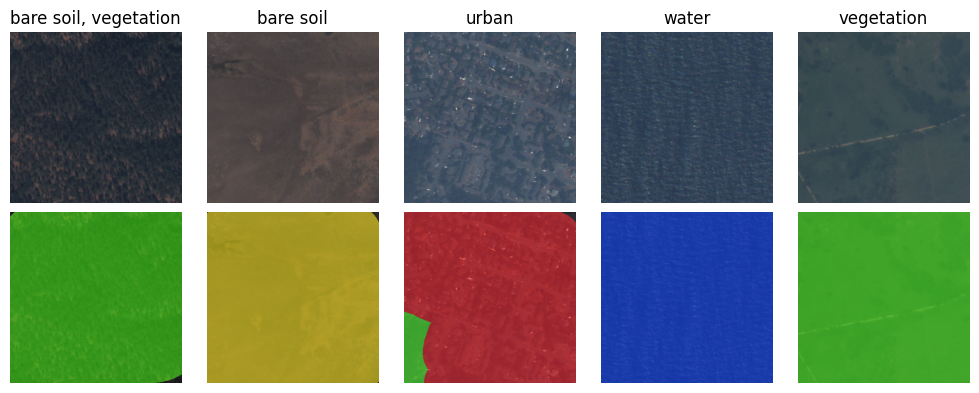

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
_colors = ['#000000'] + [ colors.get(l) for l in list(colors.keys()) ]
cmap = ListedColormap(_colors)

for col in range(5):
    mask = random.choice(masks)
    image = mask.replace('_mask.tif', '.tif')
    ds = rio.open(image)
    img = np.clip(ds.read([1,2,3]) / 4000, 0, 1)
    axes[0, col].imshow(img.transpose(1,2,0))
    axes[0, col].axis('off')
    label = gpd.read_file(image.replace('tif', 'geojson')).to_crs(ds.crs)
    label['color'] = [colors[l] for l in label['label']]
    classification = label[label['task'] == 'classification']
    # axes[1, col].imshow(np.clip(img / 4000, 0, 1))
    show(img, transform=ds.transform, ax=axes[1, col])
    axes[1, col].axis('off')
    if len(classification) > 0:
        axes[0, col].set_title(', '.join(classification['label'].values))
    else:
        axes[0, col].set_title('NO CLS')
    detection = label[label['task'] == 'detection']
    if len(detection) > 0:
        detection.plot(color=detection['color'], linewidth=1, ax=axes[1, col])
    mask = rio.open(mask).read(1)
    # axes[1, col].imshow(mask, alpha=0.3)
    # show(mask, transform=ds.transform, ax=axes[1, col])
    show(mask, transform=ds.transform, ax=axes[1, col], cmap=cmap, vmin=0, vmax=len(colors)+1, alpha=0.5)


plt.tight_layout()
plt.show()

# EDA

Let's do some EDA on the dataset.

In [24]:
task_stats = {
    'cls_img': 0,
    'det_img': 0,
    'seg_img': 0,
    'cls_anns': 0,
    'det_anns': 0,
    'seg_anns': 0
}

for label in labels:
    label = gpd.read_file(label)
    classification = label[label['task'] == 'classification']
    detection = label[label['task'] == 'detection']
    segmentation = label[label['task'] == 'segmentation']
    if len(classification) > 0:
        task_stats['cls_img'] += 1
    if len(detection) > 0:
        task_stats['det_img'] += 1
    if len(segmentation) > 0:
        task_stats['seg_img'] += 1
    task_stats['cls_anns'] += len(classification)
    task_stats['det_anns'] += len(detection)
    task_stats['seg_anns'] += len(segmentation)

task_stats

{'cls_img': 95,
 'det_img': 0,
 'seg_img': 95,
 'cls_anns': 97,
 'det_anns': 0,
 'seg_anns': 128}

In [25]:
num_samples = {k: 0 for k in list(colors.keys())}
for label in labels:
    label = gpd.read_file(label)
    classification = label[label['task'] == 'classification']
    _labels = classification.label.values
    for label in _labels:
        num_samples[label] += 1

num_samples

{'bare soil': 13, 'urban': 19, 'vegetation': 42, 'water': 23}

In [26]:
num_samples = {k: 0 for k in list(colors.keys())}
for label in labels:
    label = gpd.read_file(label)
    segmentation = label[label['task'] == 'segmentation']
    _labels = segmentation.label.values
    for label in _labels:
        num_samples[label] += 1

num_samples

{'bare soil': 26, 'urban': 22, 'vegetation': 58, 'water': 22}